# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# import random
import tensorflow as tf
from tensorflow import keras

# import os
# os.environ['PYTHONHASHSEED'] = '0'
# random.seed(12345)

tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism() # ensure reproducibility  even on GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# for gpu in physical_devices:
#     tf.config.experimental.set_memory_growth(gpu, enable=True)



2023-06-20 11:16:23.158925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 11:16:24.133712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
df = pd.read_csv('./Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

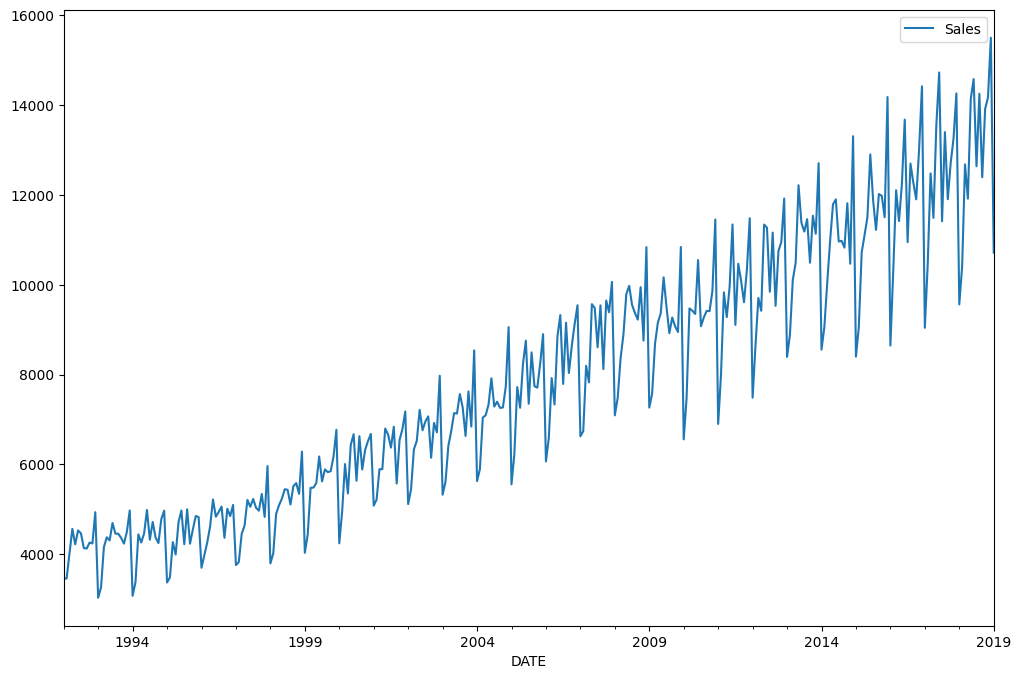

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Axes: xlabel='DATE'>

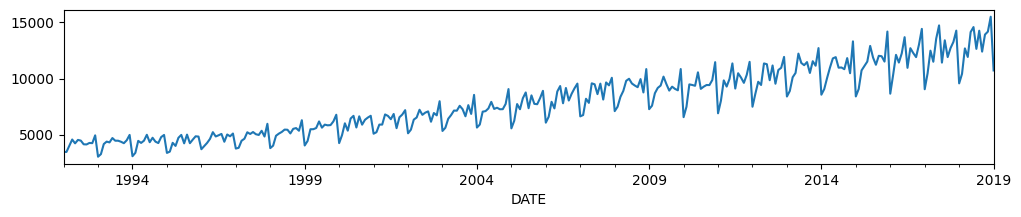

In [7]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

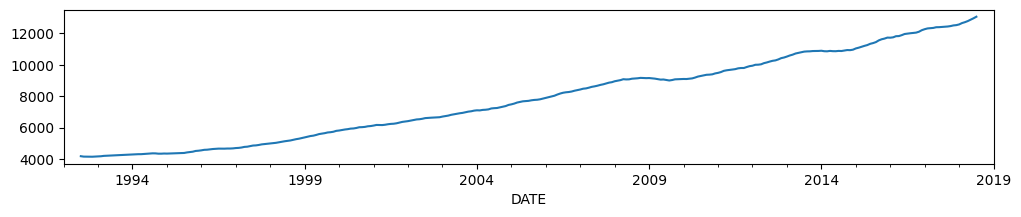

In [8]:
results.trend.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

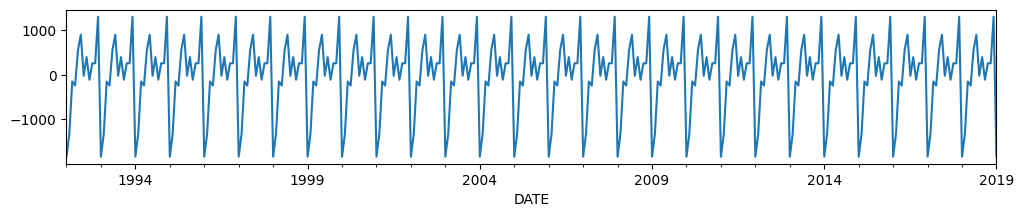

In [9]:
results.seasonal.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

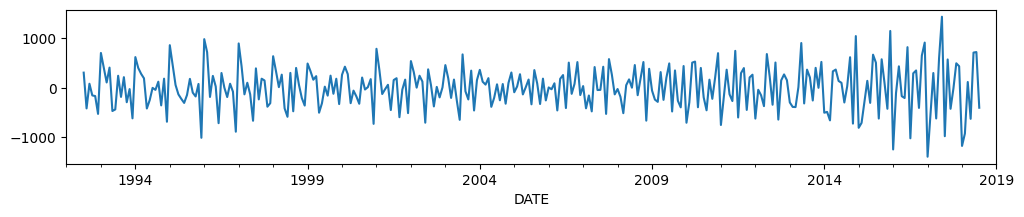

In [10]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [11]:
len(df)

325

In [12]:
325-12

313

In [13]:
train = df.iloc[:(len(df)-12)]
test = df.iloc[(len(df)-12):]

In [14]:
len(test)

12

## Scale Data

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

StandardScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# define generator
n_input = 3
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
len(scaled_train)

313

In [22]:
len(train_generator) # n_input = 3

310

In [23]:
scaled_train[:5]

array([[-1.5316005 ],
       [-1.53196284],
       [-1.33485438],
       [-1.13122395],
       [-1.25550373]])

In [24]:
# What does the first batch look like?
X,y = train_generator[0]
X.shape

(1, 3, 1)

In [25]:
X

array([[[-1.5316005 ],
        [-1.53196284],
        [-1.33485438]]])

In [26]:
y.shape

(1, 1)

In [27]:
y

array([[-1.13122395]])

In [28]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.5316005  -1.53196284 -1.33485438]
Predict this y: 
 [[-1.13122395]]


In [29]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=16)

In [30]:
# What does the first batch look like?
X,y = train_generator[0]

In [31]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.5316005  -1.53196284 -1.33485438 -1.13122395 -1.25550373 -1.14390556
 -1.16673246 -1.2859396  -1.28992525 -1.24173513 -1.24861943 -0.99643655
 -1.53196284 -1.33485438 -1.13122395 -1.25550373 -1.14390556 -1.16673246
 -1.2859396  -1.28992525 -1.24173513 -1.24861943 -0.99643655 -1.68667848
 -1.33485438 -1.13122395 -1.25550373 -1.14390556 -1.16673246 -1.2859396
 -1.28992525 -1.24173513 -1.24861943 -0.99643655 -1.68667848 -1.60334219
 -1.13122395 -1.25550373 -1.14390556 -1.16673246 -1.2859396  -1.28992525
 -1.24173513 -1.24861943 -0.99643655 -1.68667848 -1.60334219 -1.27760597
 -1.25550373 -1.14390556 -1.16673246 -1.2859396  -1.28992525 -1.24173513
 -1.24861943 -0.99643655 -1.68667848 -1.60334219 -1.27760597 -1.19897998
 -1.14390556 -1.16673246 -1.2859396  -1.28992525 -1.24173513 -1.24861943
 -0.99643655 -1.68667848 -1.60334219 -1.27760597 -1.19897998 -1.2243432
 -1.16673246 -1.2859396  -1.28992525 -1.24173513 -1.24861943 -0.99643655
 -1.68667848 -1.60334219 -1.2776059

### Create the Model

In [32]:
from keras.models import Sequential
from keras.layers import Dense # for output layer
from keras.layers import LSTM

### Hyper Parameters

In [33]:
HIDDEN_LAYER_SIZE = 12
OUTPUT_SIZE = 1
EPOCHS = 200

# use fit()
# change activation function
# add dropout layer
# add another layer

### Activation function between LSTM layers
* [as the output of LSTM cell is already activated, there is no need to add another activation function](https://datascience.stackexchange.com/questions/66594/activation-function-between-lstm-layers)
* However, by trying different settings, for this data, having an activation function relu will significantly improve the trained model

In [34]:
# define model
# what about flattening the input
model = Sequential()
model.add(LSTM(HIDDEN_LAYER_SIZE, activation='relu', input_shape=(n_input, n_features)))
# model.add(LSTM(HIDDEN_LAYER_SIZE/2, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='linear'))
# model.add(Dense(1))
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(1))
custom_optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=custom_optimizer, loss='mse')

2023-06-20 11:16:27.645014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18017 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:92:00.0, compute capability: 8.0


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12)                672       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


### fit vs fit_generator

* model.fit is used when the entire training dataset can fit into the memory and no data augmentation is applied.

* model.fit_generator is used when we have a huge dataset to fit into our memory or when data augmentation needs to be applied.
* adding *use_multiprocessing=True* adds randomness and the model cannot reproduce the same result
* **The new model.fit function can work with generator and fit_generator is depricated**

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model', 
                    monitor="loss", mode="min", 
                    save_best_only=True, verbose=1)

model.fit(train_generator,epochs=EPOCHS, callbacks=[early_stopping])
# mode_history = model.fit(x=train_generator, epochs=EPOCHS, use_multiprocessing=True, callbacks=[early_stopping, checkpoint])

Epoch 1/200


2023-06-20 11:16:28.167104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/19 [==============>...............] - ETA: 0s - loss: 0.6216

2023-06-20 11:16:29.801972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


19/19 [==============================] - 2s 22ms/step - loss: 0.5999
Epoch 2/200
19/19 [==============================] - 0s 22ms/step - loss: 0.4905
Epoch 3/200
19/19 [==============================] - 0s 22ms/step - loss: 0.3715
Epoch 4/200
19/19 [==============================] - 0s 22ms/step - loss: 0.2635
Epoch 5/200
19/19 [==============================] - 0s 21ms/step - loss: 0.1978
Epoch 6/200
19/19 [==============================] - 0s 23ms/step - loss: 0.1714
Epoch 7/200
19/19 [==============================] - 0s 22ms/step - loss: 0.1690
Epoch 8/200
19/19 [==============================] - 0s 22ms/step - loss: 0.1644
Epoch 9/200
19/19 [==============================] - 0s 21ms/step - loss: 0.1605
Epoch 10/200
19/19 [==============================] - 0s 23ms/step - loss: 0.1594
Epoch 11/200
19/19 [==============================] - 0s 22ms/step - loss: 0.1574
Epoch 12/200
19/19 [==============================] - 0s 22ms/step - loss: 0.1564
Epoch 13/200
19/19 [=================

In [37]:
# fit model
# model.fit_generator(train_generator,epochs=50)

In [38]:
model.history.history.keys()

dict_keys(['loss'])

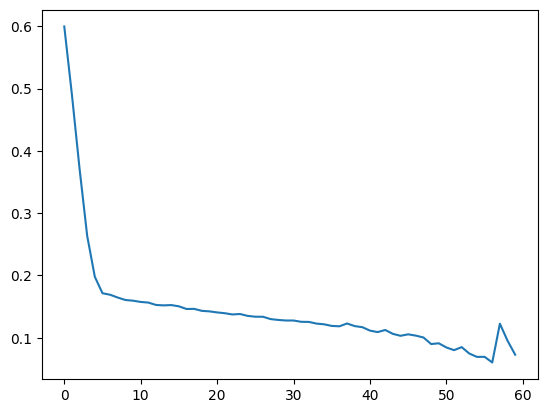

In [39]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [40]:
first_eval_batch = scaled_train[-12:]

In [41]:
first_eval_batch

array([[1.00218524],
       [1.7373563 ],
       [1.3786479 ],
       [2.12287726],
       [2.55224035],
       [1.35147302],
       [2.07106382],
       [1.52937789],
       [1.8206926 ],
       [2.01997505],
       [2.3837561 ],
       [0.68043467]])

In [42]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [43]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 195ms/step


2023-06-20 11:16:59.193185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.193449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]


array([[1.1915294]], dtype=float32)

In [44]:
scaled_test[0]

array([0.98877896])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [46]:
current_batch.shape

(1, 12, 1)

In [47]:
current_batch

array([[[1.00218524],
        [1.7373563 ],
        [1.3786479 ],
        [2.12287726],
        [2.55224035],
        [1.35147302],
        [2.07106382],
        [1.52937789],
        [1.8206926 ],
        [2.01997505],
        [2.3837561 ],
        [0.68043467]]])

In [48]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 1.7373563 ],
        [ 1.3786479 ],
        [ 2.12287726],
        [ 2.55224035],
        [ 1.35147302],
        [ 2.07106382],
        [ 1.52937789],
        [ 1.8206926 ],
        [ 2.01997505],
        [ 2.3837561 ],
        [ 0.68043467],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [49]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 37ms/step


2023-06-20 11:16:59.500664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.500934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.579282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


2023-06-20 11:16:59.727013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.727270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.803451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape

1/1 [==============================] - 0s 38ms/step


2023-06-20 11:16:59.954838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:16:59.955088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:17:00.041879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape

1/1 [==============================] - 0s 38ms/step


2023-06-20 11:17:00.188877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:17:00.189124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,12,1]
	 [[{{node Placeholder/_10}}]]
2023-06-20 11:17:00.265049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape

In [50]:
test_predictions

[array([1.1915294], dtype=float32),
 array([2.043498], dtype=float32),
 array([1.8433686], dtype=float32),
 array([2.4894397], dtype=float32),
 array([2.5090158], dtype=float32),
 array([1.8855747], dtype=float32),
 array([2.5304008], dtype=float32),
 array([2.2347052], dtype=float32),
 array([2.6498566], dtype=float32),
 array([2.712924], dtype=float32),
 array([2.5036871], dtype=float32),
 array([1.1460524], dtype=float32)]

In [51]:
scaled_test

array([[0.98877896],
       [1.81054731],
       [1.53372588],
       [2.33773997],
       [2.49897759],
       [1.79496705],
       [2.38085744],
       [1.70655811],
       [2.25657766],
       [2.35078391],
       [2.8326851 ],
       [1.09856548]])

## Inverse Transformations and Compare

In [52]:
true_predictions = scaler.inverse_transform(test_predictions)

In [53]:
true_predictions

array([[10974.5712901 ],
       [13325.92114738],
       [12773.58367083],
       [14556.6764411 ],
       [14610.70448069],
       [12890.06822419],
       [14669.72485642],
       [13853.63417428],
       [14999.41118156],
       [15173.47111655],
       [14595.99791513],
       [10849.05914273]])

In [54]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [55]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/tmp/ipykernel_948282/1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [56]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,10974.571290
2018-03-01,12683,13325.921147
2018-04-01,11919,12773.583671
2018-05-01,14138,14556.676441
2018-06-01,14583,14610.704481
2018-07-01,12640,12890.068224
2018-08-01,14257,14669.724856
2018-09-01,12396,13853.634174
2018-10-01,13914,14999.411182


<Axes: xlabel='DATE'>

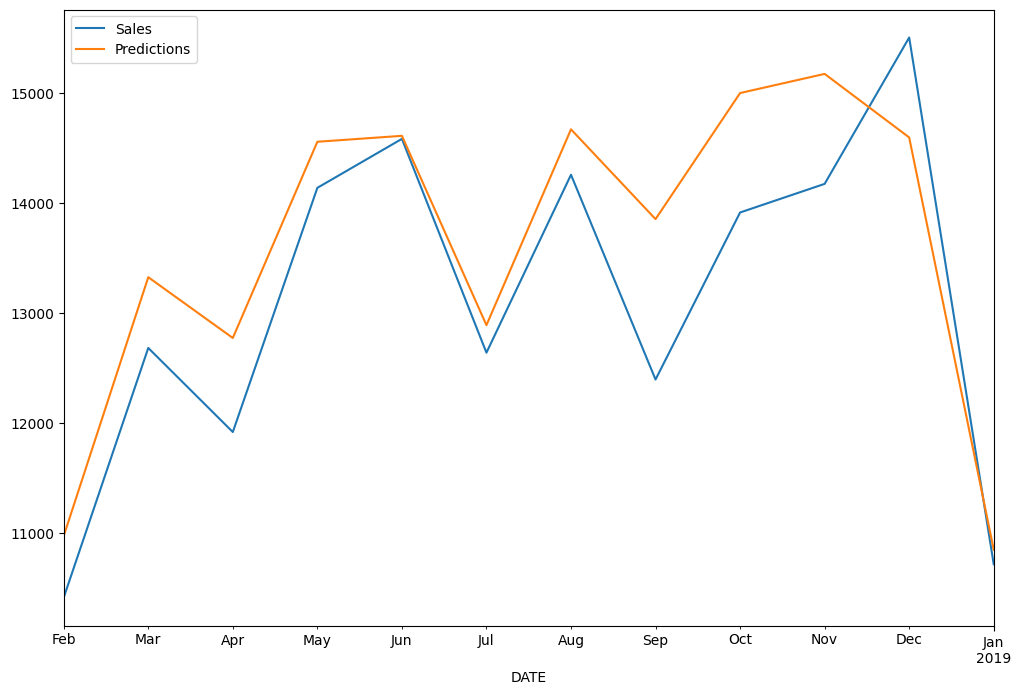

In [57]:
test.plot(figsize=(12,8))

In [58]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_true=test['Sales'], y_pred=test['Predictions'])
print(f'RMSE = {np.sqrt(error)}')
# RMSE = 1154.922582434125 RMSE = 923.4284013738093
# adding linear activation function to the output RMSE = 380.55783269376644
# batch size --> 128 RMSE = 1013.5994500392575
# batch size --> 16 RMSE = 764.2597683535672
# batch size --> 32 RMSE = 1253.6129173095483
# batch size --> 8 RMSE = 438.0748019749479
# sane batch but remove activation function on LSTM, RMSE = 1491.3037608770853




RMSE = 764.2597683535672


In [59]:
true_predictions2 = np.array([[11493.13750124],
       [12989.46475589],
       [12352.39661551],
       [14435.28201741],
       [15389.46310055],
       [12184.42744112],
       [14100.62672776],
       [12484.94429308],
       [13458.04003853],
       [13999.91077071],
       [14911.15957999],
       [10364.81182438]])
test['Predictions2'] = true_predictions2

/tmp/ipykernel_948282/3450785529.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions2'] = true_predictions2


In [60]:
error = mean_squared_error(y_true=test['Sales'], y_pred=test['Predictions2'])
print(f'RMSE = {np.sqrt(error)}')

RMSE = 511.30644073973986


# Saving and Loading Models

In [61]:
model.save('my_rnn_model.h5')

## load a model

In [62]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [63]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12)                672       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
